## Hemoglobin Prediction from Red and Infrared Signals Using PyTorch

This project demonstrates how to use a simple regression neural network in **PyTorch** to predict **hemoglobin concentration (Hb)** based on **Red** and **Infrared (IR)** light intensity values. These are inspired by signal readings commonly used in **non-invasive health monitoring** devices like pulse oximeters.

Data: `Final Dataset Hb PPG.csv` file contains historical results and haemoglobin values. This dataset is publicly available on https://data.mendeley.com/datasets/xdrwrh9zbk/2

In [ ]:
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, random_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import joblib

In [ ]:
# Load CSV
df = pd.read_csv('Final Dataset Hb PPG.csv')

# Preview data
print(df.head(8))

   Red (a.u)  Infra Red (a.u) Gender  Age (year)  Hemoglobin (g/dL)
0   115965.9         105722.9   Male          21               17.5
1   115834.4         105746.7   Male          21               17.5
2   115741.5         105786.0   Male          21               17.5
3   115707.2         105848.1   Male          21               17.5
4   115675.6         105893.5   Male          21               17.5
5   115626.1         105910.6   Male          21               17.5
6   115573.2         105904.0   Male          21               17.5
7   115436.8         105861.3   Male          21               17.5


In [ ]:
# Features and target
X = df[['Red (a.u)', 'Infra Red (a.u)']].values
y = df['Hemoglobin (g/dL)'].values.reshape(-1, 1)

In [ ]:
# Normalize features and target
x_scaler = StandardScaler()
y_scaler = StandardScaler()

X_scaled = x_scaler.fit_transform(X)
y_scaled = y_scaler.fit_transform(y)

X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
y_tensor = torch.tensor(y_scaled, dtype=torch.float32)


In [ ]:
dataset = TensorDataset(X_tensor, y_tensor)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_ds, test_ds = random_split(dataset, [train_size, test_size])

print(train_size)
print(test_size)

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=16)

652
164


In [ ]:
# Neural Network Definition
class RegressionNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 128),
            nn.LeakyReLU(),
            nn.Linear(128, 64),
            nn.LeakyReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.model(x)

In [ ]:
# Model, loss, optimizer
model = RegressionNN()
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [ ]:
# Training loop
epochs = 8000
train_losses, val_losses = [], []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = loss_fn(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation loss
    model.eval()
    with torch.no_grad():
        val_loss = sum(loss_fn(model(X_val), y_val).item() for X_val, y_val in test_loader) / len(test_loader)
        val_losses.append(val_loss)

    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {val_loss:.4f}")

Streaming output truncated to the last 5000 lines.
Epoch 3001/8000 | Train Loss: 0.0618 | Val Loss: 0.1007
Epoch 3002/8000 | Train Loss: 0.0638 | Val Loss: 0.0955
Epoch 3003/8000 | Train Loss: 0.0603 | Val Loss: 0.1008
Epoch 3004/8000 | Train Loss: 0.0614 | Val Loss: 0.1005
Epoch 3005/8000 | Train Loss: 0.0607 | Val Loss: 0.0966
Epoch 3006/8000 | Train Loss: 0.0632 | Val Loss: 0.1044
Epoch 3007/8000 | Train Loss: 0.0599 | Val Loss: 0.0939
Epoch 3008/8000 | Train Loss: 0.0633 | Val Loss: 0.0948
Epoch 3009/8000 | Train Loss: 0.0627 | Val Loss: 0.0957
Epoch 3010/8000 | Train Loss: 0.0626 | Val Loss: 0.0952
Epoch 3011/8000 | Train Loss: 0.0607 | Val Loss: 0.1026
Epoch 3012/8000 | Train Loss: 0.0618 | Val Loss: 0.1048
Epoch 3013/8000 | Train Loss: 0.0613 | Val Loss: 0.0951
Epoch 3014/8000 | Train Loss: 0.0603 | Val Loss: 0.0984
Epoch 3015/8000 | Train Loss: 0.0591 | Val Loss: 0.0960
Epoch 3016/8000 | Train Loss: 0.0614 | Val Loss: 0.0994
Epoch 3017/8000 | Train Loss: 0.0605 | Val Loss: 0.09

In [ ]:
# Save the model
torch.save(model.state_dict(), 'hb_model_weights.pth')

# Save scalers
joblib.dump(x_scaler, 'x_scaler.save')
joblib.dump(y_scaler, 'y_scaler.save')

['y_scaler.save']

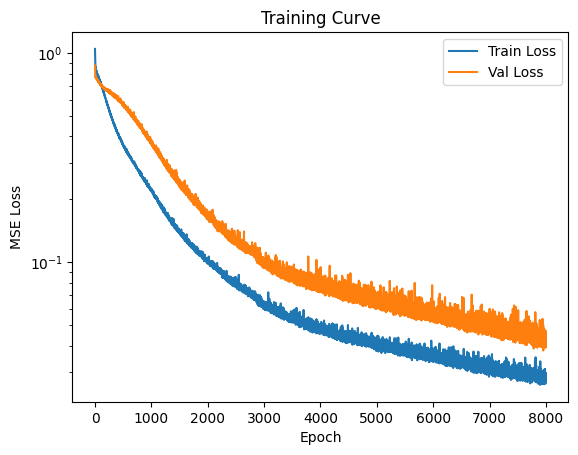

In [ ]:
# Plot training curve
plt.semilogy(train_losses, label="Train Loss")
plt.semilogy(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.title("Training Curve")
plt.show()

In [ ]:
# Evaluation on test set
model.eval()
with torch.no_grad():
    X_val, y_val = next(iter(test_loader))
    preds = model(X_val)
    preds_unscaled = y_scaler.inverse_transform(preds.numpy())
    y_val_unscaled = y_scaler.inverse_transform(y_val.numpy())
    X_val_unscaled = x_scaler.inverse_transform(X_val.numpy())

    df_preds = pd.DataFrame({
    "Red": [X_val_unscaled[i][0] for i in range(10)],
    "IR": [X_val_unscaled[i][1] for i in range(10)],
    "True Hb": [y_val_unscaled[i][0] for i in range(10)],
    "Predicted Hb": [preds_unscaled[i][0] for i in range(10)]})

    # Round values for cleaner display
    df_preds = df_preds.round(2)

    # Print the table
    print("\nSample Predictions:")
    print(df_preds.to_string(index=False))

    print("\nTest Metrics:")
    print(f"R2 Score: {r2_score(y_val_unscaled, preds_unscaled):.3f}")



Sample Predictions:
          Red            IR  True Hb  Predicted Hb
110190.203125 103750.101562     14.4         14.43
113149.796875  99645.101562     13.8         13.76
 89464.703125  88091.203125     11.5         11.45
112283.898438  86076.796875     12.9         12.90
103446.398438  91836.703125     10.1          9.97
111922.398438  93787.203125     14.3         14.10
 97114.398438  88542.601562     14.1         13.27
115247.398438 109625.101562     10.6         10.68
 81651.601562  74262.601562     12.8         13.02
111528.296875  85979.101562     12.9         12.93

Test Metrics:
R2 Score: 0.977


In [ ]:
import torch
import torch.nn as nn
import joblib
import numpy as np

# Define model architecture
class RegressionNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 128),
            nn.LeakyReLU(),
            nn.Linear(128, 64),
            nn.LeakyReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.model(x)

# Load scalers
x_scaler = joblib.load('x_scaler.save')
y_scaler = joblib.load('y_scaler.save')

# Load model
model = RegressionNN()
model.load_state_dict(torch.load('hb_model_weights.pth'))
model.eval()

# Get user input
try:
    red_input = float(input("Enter Red value: "))
    ir_input = float(input("Enter Infra Red value: "))
except ValueError:
    print("Invalid input. Please enter numeric values.")
    exit()

# Preprocess
input_array = np.array([[red_input, ir_input]])
input_scaled = x_scaler.transform(input_array)
input_tensor = torch.tensor(input_scaled, dtype=torch.float32)

# Predict
with torch.no_grad():
    prediction_scaled = model(input_tensor).numpy()
    prediction = y_scaler.inverse_transform(prediction_scaled)

print("\nInput Values You Entered:")
print(f"Red: {red_input}, Infra Red: {ir_input}")

print(f"\nPredicted Hemoglobin Level: {prediction[0][0]:.2f} g/dL")

Enter Red value: 91497.7
Enter Infra Red value: 90888.7

Input Values You Entered:
Red: 91497.7, Infra Red: 90888.7

Predicted Hemoglobin Level: 14.67 g/dL
